In [4]:
import io
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import tensorflow as tf
from keras.utils import normalize, to_categorical
import shutil

plt.style.use("ggplot")
%matplotlib inline

In [6]:
df = pd.read_csv(os.path.join('eye_dataset','data.csv'))

In [7]:
image_path = os.path.join('eye_dataset','dataset_eye','4793_left.jpeg')
label_file = os.path.join('eye_dataset','data.csv')

In [4]:
df

,image,level
0,21238_left,0
1,5772_left,0
2,31511_right,0
3,34784_left,0
4,35681_left,0
...,...,...
4276,44200_right,3
4277,44247_left,4
4278,44247_right,4
4279,44249_left,4


## Preprocess

In [8]:
def load_image(image_name):
    image_path = os.path.join('eye_dataset', 'dataset_eye', f'{image_name}.jpeg')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    
    return tf.cast(image,dtype=tf.float32)

In [9]:
def load_label(image_path:str):
    image_token = []
    label_token = []
    image_filename = image_path.split('\\')[-1].split('.')[0]
    with open (label_file ,'r') as f:
        files = f.readlines()
        for file in files[1:]:
            if image_filename == file.strip().split(',')[0]:
                image_token.append(file.strip().split(',')[0])
                label_token.append(file.strip().split(',')[1])
    return image_token,label_token

In [10]:
def convert_into_array(file):
    file = np.array(file,dtype=float)
    file = to_categorical(file,num_classes=5)
    file = tf.squeeze(file,axis=0)
    return file

In [11]:
def cropping_image(image):
    percentage = 0.02
    threshold = 0.1 * tf.reduce_mean(tf.boolean_mask(image, image != 0))
    img = tf.cast(image > threshold, tf.float32)

    row_sum = tf.reduce_sum(img, axis=1)
    col_sum = tf.reduce_sum(img, axis=0)
    rows = tf.where(row_sum > img.shape[1] * percentage)[:, 0]
    cols = tf.where(col_sum > img.shape[0] * percentage)[:, 0]

    min_row, min_col = tf.reduce_min(rows), tf.reduce_min(cols)
    max_row, max_col = tf.reduce_max(rows), tf.reduce_max(cols)

    img_crop = image[min_row:max_row + 1, min_col:max_col + 1]
    return tf.cast(img_crop,dtype = tf.float32)

In [12]:
def Normalization(image,image_size):
    
    image   = tf.image.resize(image,(image_size,image_size))
    mean_per_channel = tf.reduce_mean(image, axis=(0, 1))
    std_per_channel  = tf.math.reduce_std(image,axis=(0,1))
    
    epsilon = 1e-8
    std_per_channel = tf.maximum(std_per_channel, epsilon)

    # Normalize each channel by subtracting its respective channel mean from each pixel value
    normalized_rgb_image = image - mean_per_channel
    normalized_rgb_image = normalized_rgb_image/std_per_channel
    
    return tf.cast(normalized_rgb_image,dtype=tf.float32)

In [13]:
def preprocess(image_name,image_size = 256):
    image   = load_image(image_name)
    #image_c = cropping_image(image)
    image_n = Normalization(image,image_size)
    return tf.cast(image_n,dtype = tf.float32)

In [14]:
def load_data(path:str):
    path = bytes.decode(path.numpy())

    image,label = load_label(path)
    image = ''.join(image)
    label = convert_into_array(label)
    
    image_pre = preprocess(image,image_size=256)
    
    return image_pre,label

In [12]:
a,b = load_data(tf.convert_to_tensor('16_left'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


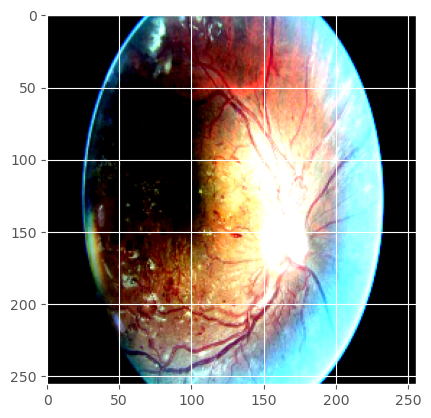

In [13]:
plt.imshow(a)

In [15]:
def mappable_function2(path:str):
    image,label = tf.py_function(load_data,[path],(tf.float32,tf.float32))
    image.set_shape([256,256,3])
    label.set_shape([5])
    return image,label

In [16]:
data = tf.data.Dataset.list_files('eye_dataset\\dataset_eye\\*.jpeg')
data = data.shuffle(buffer_size=500,reshuffle_each_iteration=False)
data = data.map(mappable_function2)
data = data.batch(32)
data = data.prefetch(tf.data.AUTOTUNE)

In [17]:
sample = data.as_numpy_iterator().next()

In [17]:
sample[0][15].shape

(256, 256, 3)

In [18]:
train_data = data.take(94)
test_data  = data.skip(94)

In [2]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate,Conv2D,Dense,Flatten
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50

In [20]:
model = Sequential()
model.add(ResNet50(input_shape=(256,256,3),include_top=False,weights=None))
for layer in model.layers:
    layer.trainable = False
model.add(Flatten())
model.add(Dense(16,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(units= 5, activation='softmax'))

In [21]:
early_stop    = EarlyStopping(monitor='val_loss',patience=5,verbose=1)
checkpoint_cb = ModelCheckpoint("model_checkpoint.h5",save_best_only=True)

In [22]:
from sklearn.metrics import cohen_kappa_score

In [23]:
def cohen_kappa(y_true, y_pred):
    y_true_labels = tf.argmax(y_true, axis=1)
    y_pred_labels = tf.argmax(y_pred, axis=1)
    kappa = tf.py_function(cohen_kappa_score, (y_true_labels, y_pred_labels), tf.float32)
    return kappa

In [24]:
model.compile(optimizer =RMSprop(centered=True) ,loss = 'categorical_crossentropy', metrics = ['accuracy','AUC'])

In [25]:
history = model.fit(train_data,validation_data=test_data,epochs=20,
                    callbacks=[early_stop,checkpoint_cb])

Epoch 1/20
94/94 [==============================] - 232s 2s/step - loss: 1.8285 - accuracy: 0.2144 - auc: 0.5213 - val_loss: 1.7635 - val_accuracy: 0.2451 - val_auc: 0.5617
Epoch 2/20
94/94 [==============================] - 206s 2s/step - loss: 1.6975 - accuracy: 0.2301 - auc: 0.5345 - val_loss: 1.6622 - val_accuracy: 0.2506 - val_auc: 0.5727
Epoch 3/20
94/94 [==============================] - 199s 2s/step - loss: 1.6474 - accuracy: 0.2327 - auc: 0.5476 - val_loss: 1.6753 - val_accuracy: 0.2498 - val_auc: 0.5680
Epoch 4/20
94/94 [==============================] - 200s 2s/step - loss: 1.6114 - accuracy: 0.2533 - auc: 0.5696 - val_loss: 1.5968 - val_accuracy: 0.2867 - val_auc: 0.5975
Epoch 5/20
94/94 [==============================] - 203s 2s/step - loss: 1.6035 - accuracy: 0.2364 - auc: 0.5659 - val_loss: 1.5536 - val_accuracy: 0.2726 - val_auc: 0.6083
Epoch 6/20
94/94 [==============================] - 196s 2s/step - loss: 1.5795 - accuracy: 0.2729 - auc: 0.5899 - val_loss: 1.5546 - v

In [26]:
early_stop    = EarlyStopping(monitor='val_loss',patience=10,verbose=1)
checkpoint_cb = ModelCheckpoint("model_checkpoint_70_epoch.h5",save_best_only=True)

In [27]:
history = model.fit(train_data,validation_data=test_data,epochs=50,
                    callbacks=[early_stop,checkpoint_cb])

Epoch 1/50
94/94 [==============================] - 197s 2s/step - loss: 1.4927 - accuracy: 0.3311 - auc: 0.6625 - val_loss: 1.4300 - val_accuracy: 0.4030 - val_auc: 0.7255
Epoch 2/50
94/94 [==============================] - 204s 2s/step - loss: 1.4919 - accuracy: 0.3374 - auc: 0.6632 - val_loss: 1.4638 - val_accuracy: 0.3417 - val_auc: 0.6842
Epoch 3/50
94/94 [==============================] - 204s 2s/step - loss: 1.4743 - accuracy: 0.3358 - auc: 0.6760 - val_loss: 1.4008 - val_accuracy: 0.4046 - val_auc: 0.7296
Epoch 4/50
94/94 [==============================] - 196s 2s/step - loss: 1.4852 - accuracy: 0.3481 - auc: 0.6692 - val_loss: 1.4214 - val_accuracy: 0.3998 - val_auc: 0.7161
Epoch 5/50
94/94 [==============================] - 197s 2s/step - loss: 1.4705 - accuracy: 0.3361 - auc: 0.6782 - val_loss: 1.3928 - val_accuracy: 0.4069 - val_auc: 0.7368
Epoch 6/50
94/94 [==============================] - 196s 2s/step - loss: 1.4704 - accuracy: 0.3354 - auc: 0.6754 - val_loss: 1.4360 - v

In [28]:
early_stop    = EarlyStopping(monitor='val_loss',patience=15,verbose=1)
checkpoint_cb = ModelCheckpoint("model_checkpoint_150_epoch.h5",save_best_only=True)

In [29]:
history = model.fit(train_data,validation_data=test_data,epochs=80,
                    callbacks=[early_stop,checkpoint_cb])

Epoch 1/80
94/94 [==============================] - 203s 2s/step - loss: 1.2466 - accuracy: 0.4458 - auc: 0.7843 - val_loss: 0.9900 - val_accuracy: 0.5797 - val_auc: 0.8740
Epoch 2/80
94/94 [==============================] - 195s 2s/step - loss: 1.2243 - accuracy: 0.4551 - auc: 0.7932 - val_loss: 1.1331 - val_accuracy: 0.5467 - val_auc: 0.8350
Epoch 3/80
94/94 [==============================] - 194s 2s/step - loss: 1.2275 - accuracy: 0.4478 - auc: 0.7940 - val_loss: 1.2069 - val_accuracy: 0.5020 - val_auc: 0.8076
Epoch 4/80
94/94 [==============================] - 195s 2s/step - loss: 1.2396 - accuracy: 0.4641 - auc: 0.7882 - val_loss: 1.0264 - val_accuracy: 0.6064 - val_auc: 0.8822
Epoch 5/80
94/94 [==============================] - 194s 2s/step - loss: 1.2024 - accuracy: 0.4694 - auc: 0.8019 - val_loss: 1.2216 - val_accuracy: 0.4713 - val_auc: 0.7980
Epoch 6/80
94/94 [==============================] - 196s 2s/step - loss: 1.2317 - accuracy: 0.4545 - auc: 0.7928 - val_loss: 1.0416 - v

In [41]:
early_stop    = EarlyStopping(monitor='val_loss',patience=15,verbose=1)
checkpoint_cb = ModelCheckpoint("model_checkpoint_150a_epoch.h5",save_best_only=True)

In [1]:
'''history = model.fit(train_data,validation_data=test_data,epochs=40,
                    callbacks=[early_stop,checkpoint_cb])'''

NameError: name 'model' is not defined

In [5]:
loadModel = tf.keras.models.load_model('model_checkpoint_150a_epoch.h5')


In [19]:
pred = loadModel.predict(sample[0])

1/1 [==============================] - 0s 50ms/step


In [22]:
np.argmax(sample[1],axis=1)

array([4, 3, 4, 1, 4, 3, 0, 3, 0, 3, 2, 2, 4, 1, 4, 2, 0, 0, 4, 2, 0, 3,
       0, 0, 3, 2, 3, 3, 0, 0, 3, 4], dtype=int64)

In [24]:
np.argmax(pred,axis=1)

array([4, 3, 4, 1, 4, 1, 4, 3, 2, 3, 2, 2, 2, 0, 4, 2, 1, 0, 4, 4, 3, 3,
       2, 3, 2, 2, 3, 3, 2, 0, 3, 2], dtype=int64)